In [2]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill
import datetime as dt
import from_config.dev.testtraindata as dl
import wandb
graph_data=dl.graph_data

Notebook
GPU detected


In [229]:
# os.chdir('from_config')
batch_size=2048
dataset=graph_data(n_steps=10, n_neighbors=31, restart=False, traintest='mix')
loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)
# os.chdir('..')

Loading mixed data to memory


In [29]:


from spektral.layers import GraphSageConv, MessagePassing
from spektral.layers.pooling.global_pool import GlobalMaxPool, GlobalAvgPool, GlobalSumPool

from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Dropout, multiply
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.sparse import SparseTensor

eps=1e-5

print('loading model')

d_act=LeakyReLU(alpha=0.15)

def no_norm(x, training):
  return x

class KHist(Model):
    def __init__(self,hist, n_out = 3, n_sigs=2, K=[1,2], agg_method='min', hidden_states=40, glob=True, conv_layers=2, conv_activation='relu', decode_layers=2, decode_activation=1, regularization=None, dropout=0.2, batch_norm=True, forward=True):
        super().__init__()
        self.hist=hist
        self.n_out=n_out
        self.n_sigs=n_sigs
        self.hidden_states=hidden_states
        self.conv_activation=conv_activation
        self.forward=forward
        self.dropout=dropout
        self.glob=glob
        self.Ks=K
        self.agg_method=agg_method
        self.conv_layers=conv_layers
        self.regularize=regularization
        if type(decode_activation)==str:
          self.decode_activation=tf.keras.activations.get(decode_activation)
        else:
          self.decode_activation=d_act
        self.batch_norm=batch_norm
        # Define layers of the model

        self.MPs      = [SGConv(hidden_states, hidden_states, K=K, agg_method=self.agg_method, dropout = dropout) for K in self.Ks]

        self.GCNs    = [GraphSageConv(hidden_states*int(i), activation=self.conv_activation, kernel_regularizer=self.regularize) for i in 2*2**np.arange(self.conv_layers)]

        self.Pool1   = GlobalMaxPool()
        self.Pool2   = GlobalAvgPool()
        self.Pool3   = GlobalSumPool()

        self.decode  = [Dense(i * hidden_states) for i in  2*2**np.arange(decode_layers+1,1,-1)]
        self.dropout_layers  = [Dropout(dropout) for i in range(len(self.decode))]
        if self.batch_norm:
          self.norm_layers  = [BatchNormalization() for i in range(len(self.decode))]
        else:
          self.norm_layers =  [no_norm for i in range(len(self.decode))]
        
        self.loge     = [Dense(hidden_states) for _ in range(2)]
        self.loge_out = Dense(1)
        self.angles     = [Dense(hidden_states) for _ in range(2)]
        self.angles_out = Dense(2)
        self.angle_scale= Dense(2)
        if n_sigs > 0:
          self.sigs      = [Dense(hidden_states) for i in range(2)]
          self.sigs_out  = Dense(n_sigs)

    def call(self, inputs, training = False):
        x, a, i = inputs
        glob_avg=tf.math.segment_mean(x,i)
        glob_var=abs(tf.math.subtract(tf.math.segment_mean(multiply([x,x]),i),multiply([glob_avg, glob_avg])))
        glob_max=tf.math.segment_max(x,i)
        glob_min=tf.math.segment_min(x,i)
        xglob=tf.concat([glob_avg, glob_var, glob_max, glob_min], axis=1)
        a, e    = self.generate_edge_features(x, a)
        for MP in self.MPs:
          x = MP([x, a, e])
        for conv in self.GCNs:
          x=conv([x,a])
        x1 = self.Pool1([x, i])
        x2 = self.Pool2([x, i])
        x3 = self.Pool3([x, i])
        x = tf.concat([x1, x2, x3], axis = 1)
        x=tf.concat([x, xglob], axis=1)
        for decode_layer, dropout_layer, norm_layer in zip(self.decode, self.dropout_layers, self.norm_layers):
          x = dropout_layer(x, training = training)
          x = self.decode_activation(decode_layer(x))
          x = norm_layer(x, training = training)
                
        x_loge = self.loge[0](x)
        x_loge = self.loge[1](x_loge)
        x_loge = self.loge_out(x_loge)

        x_angles = self.angles[0](x)
        x_angles = self.angles[1](x_angles)
        x_angles = self.angles_out(x_angles)
        zeniazi=sigmoid(self.angle_scale(x_angles))

        if self.n_sigs > 0:
          x_sigs  = self.sigs[0](x)
          x_sigs  = self.sigs[1](x_sigs)
          x_sigs  = tf.abs(self.sigs_out(x_sigs)) + eps
        #could add correlation here 
        xs=tf.stack([x_loge[:,0], zeniazi[:,0]*np.pi, zeniazi[:,1]*2*np.pi], axis = 1)
        if self.n_sigs > 0:
          return tf.concat([xs, x_sigs], axis=1)
        else:
          return xs


    def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]
      
      if self.forward == True:
        forwards  = tf.gather(x[:, 3], send) <= tf.gather(x[:, 3], receive)

        send    = tf.cast(send[forwards], tf.int64)
        receive = tf.cast(receive[forwards], tf.int64)

        a       = SparseTensor(indices = tf.stack([send, receive], axis = 1), values = tf.ones(tf.shape(send), dtype = tf.float32), dense_shape = tf.cast(tf.shape(a), tf.int64))

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return a, e

class SGConv(MessagePassing):
    # note that the D^-1/2 norm is not implemented since it is irrelevant for us 
    def __init__(self, n_out, hidden_states, K=2, agg_method='sum', dropout = 0):

        """Agg_method supports "sum": scatter_sum,
          "mean": scatter_mean,
          "max": scatter_max,
          "min": scatter_min,
          "prod": scatter_prod"""
        super().__init__()
        self.n_out = n_out
        self.agg_method=agg_method
        self.K=K
        self.hidden_states = hidden_states
        self.message_mlps = [MLP(hidden_states, hidden = hidden_states * 2, layers = 2, dropout = dropout) for _ in range(self.K)]
        self.update_mlp  = MLP(hidden_states, hidden = hidden_states, layers = 2, dropout = dropout)


    ##inverted structure since tf requires output func to be propagate
    def prop_khop(self, x, a, k, e=None, training = False, **kwargs):
        self.n_nodes = tf.shape(x)[0]
        self.index_i = a.indices[:, 1]
        self.index_j = a.indices[:, 0]

        # Message
        # print(x, a, e)
        # msg_kwargs = self.get_kwargs(x, a, e, self.msg_signature, kwargs)
        messages = self.message(x, a, k, e, training = training)

        # Aggregate
        # agg_kwargs = self.get_kwargs(x, a, e, self.agg_signature, kwargs)

        ##  make own aggregate
        embeddings = self.aggregate(messages, training = training)

        return embeddings

    def propagate(self, x, a, e, training=False):
        for hop in range(self.K):
          x=self.prop_khop(x,a, hop, e, training = training)
        return self.update(x, training = training)

    def message(self, x, a, k, e, training = False):
        # print([self.get_i(x), self.get_j(x), e])
        out = tf.concat([self.get_i(x), self.get_j(x), e], axis = 1)
        out = self.message_mlps[k](out, training = training)
        return out
    
    def update(self, embeddings, training = False):
        out = self.update_mlp(embeddings, training = training)
        return out
    
class MLP(Model):
    def __init__(self, output, hidden=256, layers=2, batch_norm=True,
                 dropout=0.0, activation='relu', final_activation=None):
        super().__init__()
        self.batch_norm = batch_norm
        self.dropout_rate = dropout

        self.mlp = Sequential()
        for i in range(layers):
            # Linear
            self.mlp.add(Dense(hidden if i < layers - 1 else output, activation = activation))
            if dropout > 0:
                self.mlp.add(Dropout(dropout))


    def call(self, inputs, training = False):
        return self.mlp(inputs, training = training)

loading model


In [30]:
model=KHist(hist=1)

In [34]:
@tf.function(input_signature = loader.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets

def predict(loader):
    prediction_list, target_list = [], []
    for batch in tqdm(loader):
        inputs, targets = batch
        predictions, targets = test_step(inputs, targets)

        prediction_list.append(predictions.numpy())
        target_list.append(targets.numpy())
        y_reco  = tf.concat(prediction_list, axis = 0).numpy()
        y_true  = tf.concat(target_list, axis = 0)
        y_true  = tf.cast(y_true, tf.float32).numpy()
    return y_reco, y_true

In [35]:
# def predictTF(loader):
#     prediction_list, target_list = [], []
#     for batch in loader:
#         inputs, targets = batch
#         predictions, targets = test_step(inputs, targets)

#         prediction_list.append(predictions.numpy())
#         target_list.append(targets.numpy())
#         y_reco  = tf.concat(prediction_list, axis = 0).numpy()
#         y_true  = tf.concat(target_list, axis = 0)
#         y_true  = tf.cast(y_true, tf.float32).numpy()
#     return y_reco, y_true

In [36]:
reco, true=predict(loader)

KeyboardInterrupt: 

In [39]:
zenith=[]
for i in tqdm(range(len(dataset))):
    zenith.append(dataset[i].y[1])
X=np.array(zenith).reshape(-1,1)

In [14]:
from sklearn.neighbors import KernelDensity

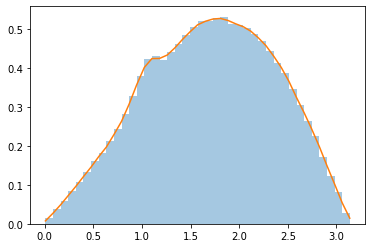

In [15]:
k=1
# Xr=np.array(reco[:,1]).reshape(-1,1)
kde=KernelDensity(kernel='gaussian', bandwidth=0.05).fit(X)
vals, bins, _=plt.hist(X, bins=40, density=1, alpha=0.4)
# _, _, _=plt.hist(Xr, bins=40, density=1, alpha=0.4)
score=np.exp(kde.score_samples(bins.reshape(-1,1)))
plt.plot(bins, score)

In [18]:
score=np.exp(kde.score_samples(bins.reshape(-1,1)))

In [17]:
bins

array([1.7130042, 1.7701238, 1.8272434, 1.884363 , 1.9414827, 1.9986023,
       2.0557218, 2.1128414, 2.169961 , 2.2270806, 2.2842002, 2.3413198,
       2.3984394, 2.455559 , 2.5126786, 2.5697982, 2.6269178, 2.6840374,
       2.741157 , 2.7982767, 2.8553963, 2.9125159, 2.9696355, 3.026755 ,
       3.0838747, 3.1409943, 3.198114 , 3.2552333, 3.312353 , 3.3694725,
       3.426592 , 3.4837117, 3.5408313, 3.597951 , 3.6550705, 3.7121902,
       3.7693098, 3.8264294, 3.883549 , 3.9406686, 3.9977882],
      dtype=float32)

In [90]:
def loss_dist(reco, true): 
    xs=np.linspace(0,np.pi/2,100)
    yr = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(reco[:,1]).evaluate(xs)
    yt = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(true[:,1]).evaluate(xs)
    return np.trapz((yr-yt)**2/np.std(yr-yt)**2, xs)

In [91]:
loss_dist(reco, true)

1.5856983291402553

In [150]:
# loss_dist(predictions, targets)

In [148]:
# for batch in next(loader:
#         inputs, targets = batch
#         predictions, targets = test_step(inputs, targets)


In [40]:
# inputs, targets = next(loader)
# predictions, targets = test_step(inputs, targets)

In [120]:
def loss_distTF(reco, true):
    reco  = tf.cast(reco, tf.float32).numpy()
    true  = tf.cast(true, tf.float32).numpy()
    yr = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(reco[:,1]).evaluate(xs)
    yt = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(true[:,1]).evaluate(xs)
    return np.trapz((yr-yt)**2/np.std(yr-yt)**2, xs)

loss_distTF(predictions, targets)

1.586384519857432

In [135]:
f = lambda x: tfd.Independent(tfd.Normal(
loc=x, scale=0.05))
kde=f(X)
xs=np.linspace(0.01,np.pi-0.01,50)
ys=[]
for x in xs:
    ys.append(tf.reduce_mean(kde.prob(tf.convert_to_tensor(x))))

In [ ]:
f = lambda x: tfd.Independent(tfd.Normal(
loc=x, scale=0.05))
kde=f(X)
xs=np.linspace(0.01,np.pi-0.01,50)
ys=[]
for x in xs:
    ys.append(tf.reduce_mean(kde.prob(tf.convert_to_tensor(x))))

In [134]:
# normals=tfd.Normal(loc=X, scale=tf.ones_like(X)*0.05, name='gauss sum')
normals=tfd.Poisson(rate=1, name='gauss sum')
normals.log_prob([1,2,3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.       , -1.6931472, -2.7917595], dtype=float32)>

In [138]:
n=len(X)
kde = tfd.MixtureSameFamily(
mixture_distribution=tfd.Categorical(
probs=[1 / n] * n),
components_distribution=tfd.Normal(loc=X, scale=tf.ones_like(X)*0.05))

In [191]:
# inputs, targets = next(loader)
# x_=list(targets[:2,1])
# kde = tfd.MixtureSameFamily(
# mixture_distribution=tfd.Categorical(
# probs=[1 / 2] * 2),
# components_distribution=tfd.Normal(loc=x_, scale=0.05))
# x=tf.linspace(0+0.01, 3.1415926-0.01, 100)
# plt.plot(x, kde.prob(x))

In [267]:
inputs, targets=next(loader)
ys=tf.convert_to_tensor(list(targets[:,1]))
# ys=tf.convert_to_tensor([1.1,2.2])
sig=tf.convert_to_tensor([0.1], tf.float64)
probs=tf.convert_to_tensor([1 / len(X)] * len(X), dtype=tf.float64)
kde0 = tfd.MixtureSameFamily(
mixture_distribution=tfd.Categorical(
probs=probs),
components_distribution=tfd.Normal(loc=X, scale=sig))
plt.plot(x, kde0.prob(x))

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a float tensor but is a double tensor [Op:Sub]

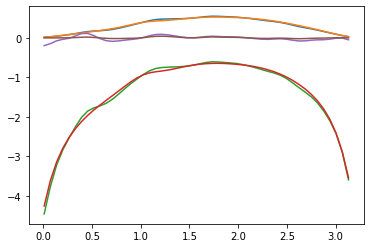

In [268]:
inputs, targets=next(loader)
ys=tf.convert_to_tensor(list(targets[:,1]))
# ys=tf.convert_to_tensor([1.1,2.2])
sig=tf.convert_to_tensor([0.1], tf.float64)
probs=tf.convert_to_tensor([1 / len(ys)] * len(ys), dtype=tf.float64)
kde1 = tfd.MixtureSameFamily(
mixture_distribution=tfd.Categorical(
probs=probs),
components_distribution=tfd.Normal(loc=ys, scale=sig))
x=tf.linspace(0+0.01, 3.1415926-0.01, 50)
x=tf.cast(x, tf.float64)
plt.plot(x, kde1.prob(x))
plt.plot(x, kde0.prob(x))
plt.plot(x,kde1.log_prob(x))
plt.plot(x,kde0.log_prob(x))
plt.plot(x,kde1.log_prob(x)-kde0.log_prob(x))
plt.plot(x,kde1.prob(x)-kde0.prob(x))

In [269]:
kl=tf.keras.losses.KLDivergence()
kl(kde0.prob(x), kde1.prob(x))

<tf.Tensor: shape=(), dtype=float64, numpy=0.013831029646098614>

In [271]:
tf.reduce_mean(tf.math.abs(kde1.log_prob(x)-kde0.log_prob(x)))

<tf.Tensor: shape=(), dtype=float64, numpy=0.04882308682802093>

In [43]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
def KDE_gauss(x, sig=0.05):
    f = lambda x: tfd.Independent(tfd.Normal(
    loc=x, scale=sig))
    n = x.shape[0]
    print(n)
    kde = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(
    probs=[1 / n] * n),
    components_distribution=f(x))
    return kde

In [72]:
X=tf.cast(X, tf.float64)
n = 1
kde = tfd.MixtureSameFamily(
mixture_distribution=tfd.Categorical(
probs=[1 / n] * n),
components_distribution=f(X[:n]))

In [73]:
kde.prob(tf.cast(0, tf.int64))

InvalidArgumentError: cannot compute Sub as input #1(zero-based) was expected to be a int64 tensor but is a double tensor [Op:Sub]

In [60]:
tf.cast(0, tf.float64)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [46]:
xs=tf.linspace(0,2,20)
kdet=KDE_gauss(X)
kdet.prob(1)

165840


InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:AddV2]

In [298]:
batch_size, sig=1024, 0.04

bins=40
loader = DisjointLoader(dataset, batch_size=batch_size, epochs=1)

In [299]:
inputs, targets = next(loader)
predictions, targets = test_step(inputs, targets)
xs=np.linspace(0,np.pi/2,20)
kdet=KDE_gauss(targets[:,1], sig=sig)
kder=KDE_gauss(predictions[:,1], sig=sig)
tdist=kdet.prob(xs)
rdist=kder.prob(xs)

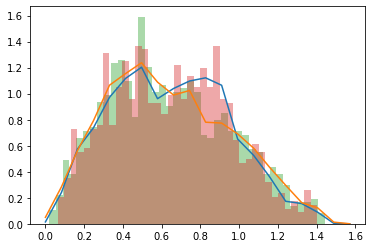

In [300]:
plt.plot(xs, rdist, label='reco')
plt.plot(xs, tdist, label='true')
plt.hist(targets[:,1].numpy(), bins=bins, density=1, alpha=0.4)
plt.hist(predictions[:,1].numpy(), bins=bins, density=1, alpha=0.4);

In [304]:
mix = 0.3
bimix = tfd.Mixture(
  cat=tfd.Categorical(probs=[mix, 1.-mix]),
  components=[
    kder,
    kdet,
])


In [310]:
KL=tf.math.reduce_sum(tdist*tf.math.log(rdist/tdist))
tfd.kl_divergence(kdet, kder)

NotImplementedError: No KL(distribution_a || distribution_b) registered for distribution_a type MixtureSameFamily and distribution_b type MixtureSameFamily

0.9984774142311947

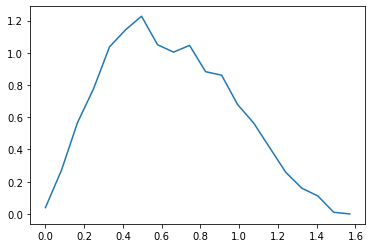

In [306]:
plt.plot(xs, bimix.prob(xs))
np.trapz(bimix.prob(xs), xs)

In [28]:
import KDEpy as kdp

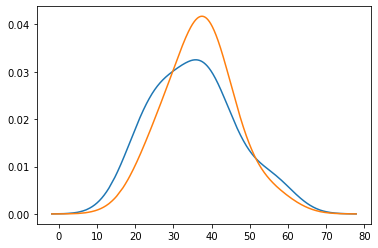

In [30]:
customer_ages = [40, 56, 20, 35, 27, 24, 29, 37, 39, 46]

# Distribution of customers
x, y = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(customer_ages).evaluate()
plt.plot(x, y)

# Distribution of customer income (weight each customer by their income)
customer_income = [152, 64, 24, 140, 88, 64, 103, 148, 150, 132]

# The `bw` parameter can be manually set, e.g. `bw=5`
x, y = kdp.FFTKDE(bw="silverman").fit(customer_ages, weights=customer_income).evaluate()
plt.plot(x, y)

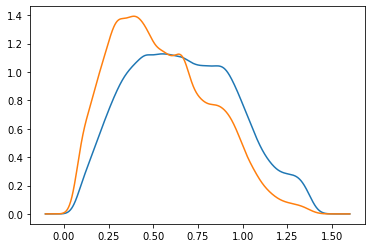

In [160]:
# Distribution of zenith
zeni=reco[:,1]
azi=reco[:,2]
zk=reco[:,3]
azk=reco[:,4]
x0, y0 = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(zeni).evaluate()
plt.plot(x0, y0)

# Distribution of customer income (weight each customer by their income)
invkap = 1/np.sqrt(zk)

# The `bw` parameter can be manually set, e.g. `bw=5`
x, y = kdp.FFTKDE(kernel='gaussian', bw="silverman").fit(zeni, weights=invkap).evaluate()
plt.plot(x, y)
# plt.hist(zeni, bins=40, density=1, alpha=.4);
# plt.hist(true[:,1], bins=40, density=1, alpha=.2);

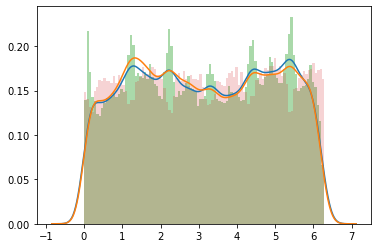

In [40]:
x, y = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(azi).evaluate()
plt.plot(x, y)

# Distribution of customer income (weight each customer by their income)
invkap = 1/np.sqrt(azk)

# The `bw` parameter can be manually set, e.g. `bw=5`
x, y = kdp.FFTKDE(kernel='gaussian', bw="silverman").fit(azi, weights=invkap).evaluate()
plt.plot(x, y)
plt.hist(azi, bins=100, density=1, alpha=.4);
plt.hist(true[:,2], bins=100, density=1, alpha=.2);

In [43]:
np.shape(y)

(1024,)

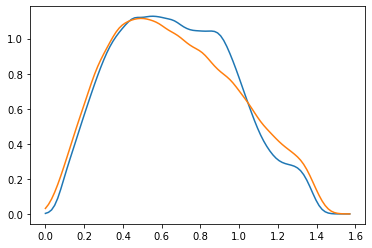

In [55]:
xs=np.linspace(0,np.pi/2,100)
yr = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(zeni).evaluate(xs)
yt = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(true[:,1]).evaluate(xs)
plt.plot(xs, yr)
plt.plot(xs, yt)

In [57]:
np.trapz(yr, xs), np.trapz(yt, xs)

(0.9999592503646962, 0.9993037112212729)

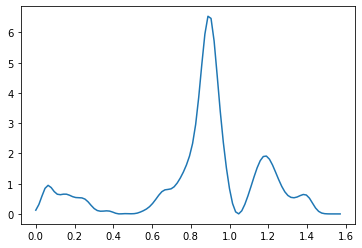

In [166]:
plt.plot(xs, (yr-yt)**2/np.std(yr-yt)**2)

In [61]:
np.trapz(np.abs(yr-yt)**2/np.std(yr-yt)**2, xs)

1.5856983291402553

In [88]:
import from_config.dev.eval_model as evals
performance_plot = evals.performance_vM2D

import from_config.dev.metrics as met
metrics=met.energy_angle_zeniazi

import from_config.dev.models as models
model = models.KHop()

import from_config.dev.loss_funcs as lf
loss_func=lf.abs_vonMises2D_angle

In [85]:
import os, sys, time, wandb
from tqdm import tqdm
import tensorflow as tf
import numpy as np

import os.path as osp

from tensorflow.keras.optimizers import Adam
from spektral.data import DisjointLoader
from importlib import __import__

cwd = osp.abspath('')

# wandblog=True
# batch_size=512
# # Setup Log 
# run = wandb.init(project = 'newloss', entity = "chri862z", group='KDEtest',\
#                  reinit=True)

################################################
#   Load dataset                              #
################################################
from from_config.dev.data_load import graph_data
#load dataset
epochs      = 20
batch_size  = 512

dataset=graph_data(n_data=2e5,transform_path='db_files/muongun/transformers.pkl',\
             db_path= 'db_files/muongun/rasmus_classification_muon_3neutrino_3mio.db', n_neighbors=14, restart=0)

idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

loader_train = DisjointLoader(dataset_train, epochs=epochs, batch_size=batch_size)
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)


 ###############################################
#   Setup other run params                     #
################################################

early_stop  = 5
patience    = 5
val_epoch = 10

# print('check')
################################################
#   Setup model, loss, lr schedule and metrics #
################################################

# Get model, metrics, lr_schedule and loss function

def classic(lr, warm_up = 3, decay = 0.9):

    def lr_schedule():
        # Intial value
        factor = lr * 1 / 2 ** warm_up
        yield factor
        
        # Multiply with 2 first few round
        for i in range(warm_up):
            factor *= 2
            yield factor

        # Make an exponential decay
        while True:
            factor *= decay
            yield factor

    return lr_schedule

lr_schedule=classic(1e-3)()

# save_path=osp.join(model_path,wandb.run.name)

# if not osp.isdir(save_path):
#     os.makedirs(save_path)
#     print('New folder for saving run made')

# Learning rate and optimizer
learning_rate            = next(lr_schedule)
opt           = Adam(learning_rate)

Loading data to memory


In [100]:
def loss_distTF(reco, true):
    xs=np.linspace(0,np.pi/2,100)
    reco  = tf.cast(reco, tf.float32).numpy()
    true  = tf.cast(true, tf.float32).numpy()
    yr = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(reco[:,1]).evaluate(xs)
    yt = kdp.FFTKDE(kernel="gaussian", bw="silverman").fit(true[:,1]).evaluate(xs)
    return np.trapz((yr-yt)**2/np.std(yr-yt)**2, xs)

In [102]:


################################################
#   Set up TF functions and validation step   #
################################################


# Define training function
@tf.function(input_signature = loader_train.tf_signature(), experimental_relax_shapes = True)
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training = True)
        targets     = tf.cast(targets, tf.float32)
        loss        = loss_func(predictions, targets)
        loss       += sum(model.losses)
        loss       +=loss_distTF(predictions, targets)

    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 

    return predictions, targets, out


def validation(loader):
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out

        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0)
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32)

    loss, loss_from = loss_func(y_reco, y_true, re=True)

    energy, e_old, alpha, zeni, azi= metrics(y_reco, y_true)

    return loss, loss_from, [energy, e_old, alpha, zeni, azi]



################################################
#  Train Model                                 #      
################################################

tot_time=0
current_batch = 0
current_epoch = 1
loss          = 0
lowest_loss   = np.inf
early_stop    = 1
early_stop_counter    = 0
pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)
start_time    = time.time()
summarylist=[]
for batch in loader_train:
    inputs, targets = batch
    out             = train_step(inputs, targets)
    loss           += out
    if current_epoch==1 and current_batch==0:
        model.summary()
        if wandblog:
            summary=model.summary(print_fn=summarylist.append)
            table=wandb.Table(columns=["Layers"])
            for s in summarylist:
                table.add_data(s)
            wandb.log({'Model summary': table})
    current_batch  += 1
    pbar.update(1)
    pbar.set_description(f"Epoch {current_epoch} / {epochs}; Avg_loss: {loss / current_batch:.6f}")

    if current_batch == loader_train.steps_per_epoch:
        t=time.time() - start_time
        tot_time+=t
        print(f"Epoch {current_epoch} of {epochs} done in {t:.2f} seconds using learning rate: {learning_rate:.2E}")
        print(f"Avg loss of train: {loss / loader_train.steps_per_epoch:.6f}")

        loader_val    = DisjointLoader(dataset_val, epochs = 1,      batch_size = batch_size)
        val_loss, val_loss_from, val_metric = validation(loader_val)
        if wandblog:
            wandb.log({"Train Loss":      loss / loader_train.steps_per_epoch,
                    "Validation Loss": val_loss, 
                    "w(log(E))":   val_metric[1],
                    "Energy bias":   val_metric[0][1],
                    "Energy sig-1":   val_metric[0][0],
                    "Energy sig+1":   val_metric[0][2],
                    "Solid angle 68th":    val_metric[2][3],
                    "Angle bias":   val_metric[2][1],
                    "Angle sig-1":   val_metric[2][0],
                    "Angle sig+1":   val_metric[2][2],
                    "zenith 68th":    val_metric[3][3],
                    "zenith bias":   val_metric[3][1],
                    "zenith sig-1":   val_metric[3][0],
                    "zenith sig+1":   val_metric[3][2],
                    "azimuth 68th":    val_metric[4][3],
                    "azimuth bias":   val_metric[4][1],
                    "azimuth sig-1":   val_metric[4][0],
                    "azimuth sig+1":   val_metric[4][2],
                    "Learning rate":   learning_rate})
        print("\n")
        if not construct_dict['run_params']['zeniazi_metric']:
            print(f"Avg loss of validation: {val_loss:.6f}")
            print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
            print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}")
        else:
            print(f"Avg loss of validation: {val_loss:.6f}")
            print(f"Loss from:  Energy: {val_loss_from[0]:.6f} \t Angle: {val_loss_from[1]:.6f} ")
            print(f"Energy: bias = {val_metric[0][1]:.6f} sig_range = {val_metric[0][0]:.6f}<->{val_metric[0][2]:.6f}, old metric {val_metric[1]:.6f}\
                \n Angle: bias = {val_metric[2][1]:.6f} sig_range = {val_metric[2][0]:.6f}<->{val_metric[2][2]:.6f}, old metric {val_metric[2][3]:.6f}\
                \n Zenith: bias = {val_metric[3][1]:.6f} sig_range = {val_metric[3][0]:.6f}<->{val_metric[3][2]:.6f}, old metric {val_metric[3][3]:.6f}\
                \n Azimuth: bias = {val_metric[4][1]:.6f} sig_range = {val_metric[4][0]:.6f}<->{val_metric[4][2]:.6f}, old metric {val_metric[4][3]:.6f}")

        if val_loss < lowest_loss:
            early_stop_counter = 0
            lowest_loss        = val_loss
        else:
            early_stop_counter += 1
        print(f'Early stop counter: {early_stop_counter}/{patience}, lowest val loss was {lowest_loss:.6f}')
        if early_stop and (early_stop_counter >= patience):
            print(f"Stopped training. No improvement was seen in {patience} epochs")

        if current_epoch != epochs:
            pbar          = tqdm(total = loader_train.steps_per_epoch, position=0, leave = True)

        learning_rate = next(lr_schedule)
        opt.learning_rate.assign(learning_rate)

        time_avg=tot_time/current_epoch
        if current_epoch % val_epoch == 0:
            model.save(save_path)
            print("Model saved")
            if wandblog:
                loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
                fig, _ = performance_plot(loader_test, test_step, metrics, save=True, save_path=save_path)
                title="performanceplot_"+str(current_epoch)
                wandb.log({title: [wandb.Image(fig, caption=title)]})

        loss            = 0
        start_time      = time.time()
        current_epoch  += 1
        current_batch   = 0


  0%|                                                                                          | 0/313 [00:20<?, ?it/s]


AttributeError: in user code:

    <ipython-input-102-a72224c3e38c>:14 train_step  *
        loss       +=loss_distTF(predictions, targets)
    <ipython-input-100-8ef078adaeb6>:3 loss_distTF  *
        reco  = tf.cast(reco, tf.float32).numpy()

    AttributeError: 'Tensor' object has no attribute 'numpy'
